# More check with guide bundle

### Jan. 3rd, 2019

In the last meeting, Michael commented that it is a bit strange that guide bundles more than 30 makes the fitting **worse**, and probably this may mean that my current method is not stable yet.
However, I believe that the above problem might be due to that I put all random guide bundles at once, so that too many guide bundles will be too crowded and it will be hard to correctly match their pixel positions and plate positions.
Since the maximum number of guide bundles will be something like 19, let's assume that we can take multiple different exposures.

As a fiducial choice, let's use the previous three step iteration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import interpolate as itpl

In [2]:
def ReadPlatePos(prefix):
    rawData = np.genfromtxt("../08_mod01_07_dataWithROCCorrection/%s.dat" % (prefix))
    arrPlt,arrPix = rawData[:,2:5],rawData[:,5:7]
    return arrPlt

In [3]:
class Parameter:
    def __init__(self):
        self.ROC = 3265.
        self.DFOV = 1200.
        self.fc = 7246.376812
        self.Tc = np.array([0,-299.408892,-3261.955597])
        self.Rc = np.array([0,0,0])	# Rotation in units of rad...
        self.kc = np.array([-0.2,0,0,0,0])		# radial distortion coefficients
        self.cc = np.array([1224,1025])
        
        
def GetFiducialParameter(prefix):
    params = Parameter()  # See Parameter::__init__ for the definition of other parameters
    params.Rc = np.array([0,0,0])	# Rotation in units of rad... see below
    
    if prefix == "MANIFEST_sim_001_coord_data_camera-1":
        params.Rc = np.array([0.097242,-0.097242,1.568608])
    elif prefix == "MANIFEST_sim_001_coord_data_camera-2":
        params.Rc = np.array([0.120983,0.032417,-0.522923])
    elif prefix == "MANIFEST_sim_001_coord_data_camera-3":
        params.Rc = np.array([0.043415,0.162026,-2.613643])
        
    return params

In [4]:
def ChangeFiducialParameter(params,valType,valPercent):
    if valPercent < -1 or valPercent > 1:
        print("Error: value error should be between -1% ~ +1%!!!")
        return params
    frac = 1.+valPercent*0.01
    
    newParams = Parameter()
    newParams.fc = params.fc
    newParams.Tc = np.copy(params.Tc)
    newParams.Rc = np.copy(params.Rc)
    newParams.kc = np.copy(params.kc)
    newParams.cc = np.copy(params.cc)
    
    if valType == "fc":
        newParams.fc *= frac
    elif valType[:2] == "Tc":
        TcTotSq = newParams.Tc[0]**2 + newParams.Tc[1]**2 + newParams.Tc[2]**2
        if valType[2] == '0':
            newParams.Tc[0] = 0.01*valPercent*newParams.Tc[1]
        else:
            newParams.Tc[1] *= frac
        newParams.Tc[2] = -np.sqrt(TcTotSq - newParams.Tc[0]**2 - newParams.Tc[1]**2)
    elif valType[:2] == "Rc":
        newParams.Rc[np.int(valType[2])] *= frac
    elif valType[:2] == "kc":
        if valType[2] == '0':
            newParams.kc[0] *= frac
        else:
            newParams.kc[np.int(valType[2])] = 1E-6*valPercent
    elif valType[:2] == "cc":
        newParams.cc[np.int(valType[2])] *= frac
    else:
        print("Error: type should be either (fc, Tc#, Rc#, kc#, cc#)")
    return newParams

In [5]:
def ConvertPlateToPix(arrPlate,params):
    
    cameraMatrix = np.array([[params.fc,0,params.cc[0]],[0,params.fc,params.cc[1]],[0,0,1]],dtype=np.float64)
    #print("Before cv2.projectPoints: Rc = ",params.Rc,params.Rc.dtype,flush=True)
    arrPix,jac = cv2.projectPoints(np.copy(arrPlate),np.array(params.Rc,dtype=np.float64),np.array(params.Tc,dtype=np.float64),cameraMatrix,params.kc)
    arrPix = arrPix.reshape(-1,2)
    
    return arrPix

"""
Returns two maps : (Xpix,Ypix) ---> (Xplt) and (Xpix,Ypix) ---> (Yplt)
from given plate alignment/camera distortion parameters and spline interpolation setup.

Input:
- params : Parameter() object that contains plate alignment/camera distortion parameters.
- kind : kind of spline interpolation ('linear','cubic','quintic')
- Ngrid : number of grids from -DFOV/2 to +DFOV/2

Output:
- mapXYpixToXplt : mapping function of (Xpix,Ypix) ---> (Xplt)
- mapXYpixToYplt : mapping function of (Xpix,Ypix) ---> (Yplt)
"""
def MakeMapPixToPlate(params,kind,Ngrid):
    
    """Step 1. Make the grid for X_plate and Y_plate"""
    Xplt,Yplt = np.mgrid[-params.DFOV*0.5:params.DFOV*0.5:Ngrid*1j,-params.DFOV*0.5:params.DFOV*0.5:Ngrid*1j]
    Xplt,Yplt = Xplt.flatten(),Yplt.flatten()
    #print("Dimension of Xplt : ",Xplt.shape)

    """Step 2. Calculate the Z_plate for each X_plate and Y_plate, and stack it"""
    Zplt = np.sqrt(params.ROC**2-Xplt**2-Yplt**2) - params.ROC
    XYZplt = np.vstack([Xplt,Yplt,Zplt]).T
    #print("Dimension of XYZplt : ",XYZplt.shape)

    """Step 3. Project 3D points to an image plane, by using OpenCV"""
    cameraMatrix = np.array([[params.fc,0,params.cc[0]],[0,params.fc,params.cc[1]],[0,0,1]])
    XYpix,Jacob = cv2.projectPoints(XYZplt,params.Rc,params.Tc,cameraMatrix,params.kc)
    XYpix = XYpix.reshape(-1,2)
    #print("Dimension of XYpix : ",XYpix.shape)

    """Step 4. Construct maps to find (Xpix,Ypix) ---> (Xplt) and (Xpix,Ypix) ---> (Yplt)"""
    mapXYpixToXplt = itpl.interp2d(XYpix[:,0],XYpix[:,1],Xplt,kind=kind)
    mapXYpixToYplt = itpl.interp2d(XYpix[:,0],XYpix[:,1],Yplt,kind=kind)

    return mapXYpixToXplt,mapXYpixToYplt

    
    
"""
Returns X/Y/Z plate position from a given X/Y camera position and mappin functions.

Input:
- arrPixPos : X/Y camera position in units of px.
- mapXYpixToXplt : mapping function of (Xpix,Ypix) ---> (Xplt)
- mapXYpixToYplt : mapping function of (Xpix,Ypix) ---> (Yplt)
- params : Parameter() object that contains plate alignment/camera distortion parameters.

Output:
	- XYZplt : X/Y/Z plate position in units of mm.
"""
def ConvertPixToPlate(arrPix,mapXYpixToXplt,mapXYpixToYplt,params):

    """Step 1. Get the Xplt and Yplt"""
    Xplt = np.array([mapXYpixToXplt(x,y) for x,y in arrPix]).flatten()
    Yplt = np.array([mapXYpixToYplt(x,y) for x,y in arrPix]).flatten()
    #print("Dimension of Xplt : ",Xplt.shape)

    """Step 2. Get the Zplt from Xplt and Yplt, and stack it"""
    Zplt = np.sqrt(params.ROC**2-Xplt**2-Yplt**2) - params.ROC
    XYZplt = np.vstack([Xplt,Yplt,Zplt]).T
    #print("Dimension of XYZplt : ",XYZplt.shape)

    return XYZplt

In [6]:
def MakePlateFiducial(N,radius,ROC):
    arrTheta = np.arange(N)*(2.*np.pi/N)
    arrX,arrY = radius*np.cos(arrTheta),radius*np.sin(arrTheta)
    arrZ = np.sqrt(ROC**2-arrX**2-arrY**2) - ROC
    
    return np.vstack([arrX,arrY,arrZ]).T

In [7]:
def CollectPixWithinFrame(arrOld,width,height):
    indx = (arrOld[:,0] >= 0) & (arrOld[:,0] < width) & (arrOld[:,1] >= 0) & (arrOld[:,1] < height)
    return arrOld[indx,:]

def GetFiducialSubset(arrPlate,arrPixFid,arrPixNew):
    arrPlateSub = []
    for pixNew in arrPixNew:
        diffSq = (arrPixFid[:,0]-pixNew[0])**2 + (arrPixFid[:,1]-pixNew[1])**2
        indx = np.argmin(diffSq)
        arrPlateSub.append(arrPlate[indx,:])
        
    return np.array(arrPlateSub)

In [8]:
def ChangeFullFiducialParameter(paramOrig,arrPercent):
    params = ChangeFiducialParameter(paramOrig,"Tc0",arrPercent[0])
    params = ChangeFiducialParameter(params,"Tc1",arrPercent[1])
    params = ChangeFiducialParameter(params,"Rc0",arrPercent[2])
    params = ChangeFiducialParameter(params,"Rc1",arrPercent[3])
    params = ChangeFiducialParameter(params,"Rc2",arrPercent[4])
    params = ChangeFiducialParameter(params,"fc",arrPercent[5])
    params = ChangeFiducialParameter(params,"kc0",arrPercent[6])
    params = ChangeFiducialParameter(params,"kc1",arrPercent[7])
    params = ChangeFiducialParameter(params,"kc2",arrPercent[8])
    params = ChangeFiducialParameter(params,"kc3",arrPercent[9])
    params = ChangeFiducialParameter(params,"kc4",arrPercent[10])
    params = ChangeFiducialParameter(params,"cc0",arrPercent[11])
    params = ChangeFiducialParameter(params,"cc1",arrPercent[12])
    
    return params

In [9]:
def MakeGuideBundle(N,radius,ROC):
    arrRand = np.random.rand(N,2)
    arrR,arrTheta = radius*np.sqrt(arrRand[:,0]),2.*np.pi*arrRand[:,1]
    arrX,arrY = arrR*np.cos(arrTheta),arrR*np.sin(arrTheta)
    arrZ = np.sqrt(ROC**2 - arrX**2 - arrY**2) - ROC
    
    return np.vstack([arrX,arrY,arrZ]).T

In [10]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalParam = [Tc[0],Tc[1],Rc[2],fc,cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalFid = np.array([paramsFid.Tc[0],paramsFid.Tc[1],paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    probableFid = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundantFid = np.copy(paramsFid.kc[1:])
        
    criticalLP,criticalHP = criticalFid*0.99,criticalFid*1.01
    probableLP,probableHP = probableFid*0.99,probableFid*1.01
    
    criticalLB = np.minimum(criticalLP,criticalHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    criticalUB = np.maximum(criticalLP,criticalHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalParam --> probableParam --> redundantParam
    # Here, calibrate multiple times
    critical,probable,redundant = np.copy(criticalFid),np.copy(probableFid),np.copy(redundantFid)
    for iteration in range(100):
        criticalOld,probableOld,redundantOld = np.copy(critical),np.copy(probable),np.copy(redundant)
        critical = opt.least_squares(ResidueChangeCritical,criticalOld,
                                     args=(arrPlate,arrPix,probableOld,redundantOld),
                                     bounds=(criticalLB,criticalUB),
                                     ftol=1E-16,xtol=1E-16).x
        probable = opt.least_squares(ResidueChangeProbable,probableOld,
                                     args=(arrPlate,arrPix,critical,redundantOld),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
        redundant = opt.least_squares(ResidueChangeRedundant,redundantOld,
                                      args=(arrPlate,arrPix,critical,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((critical-criticalOld)/criticalOld)),
                  np.amax(np.abs((probable-probableOld)/probableOld)),
                  np.amax(np.abs((redundant-redundantOld)/redundantOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(critical,probable,redundant)
    return newParam

In [11]:
def ConstructParameter(criticalParam,probableParam,redundantParam):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalParam[0],criticalParam[1],-np.sqrt(TcSq - criticalParam[0]**2 - criticalParam[1]**2)])
    params.Rc = np.array([probableParam[0],probableParam[1],criticalParam[2]])
    params.fc = criticalParam[3]
    params.kc = np.array([probableParam[2],redundantParam[0],redundantParam[1],redundantParam[2],redundantParam[3]])
    params.cc = np.array([criticalParam[4],criticalParam[5]])
    return params

def ResidueChangeCritical(criticalParam,arrPlate,arrPix,probableParam,redundantParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeProbable(probableParam,arrPlate,arrPix,criticalParam,redundantParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeRedundant(redundantParam,arrPlate,arrPix,criticalParam,probableParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

In [12]:
def CreateGuideBundleSet(Nset):
    NGB,DFOV,ROC = 19,1200.,3265.
    rawPlateGB = MakeGuideBundle(NGB*Nset,DFOV*0.5,ROC)
    plateGB = rawPlateGB.reshape((Nset,NGB,3))
    return plateGB

In [13]:
plateGBSet = CreateGuideBundleSet(100)

In [31]:
def TestFitting(filename,Nset):

    WIDTH,HEIGHT = 2448,2050

    # Get the fiducial choice for camera 1
    prefix = "MANIFEST_sim_001_coord_data_camera-1"
    params = GetFiducialParameter(prefix)
    plateTarget = ReadPlatePos(prefix)
    plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
    pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

    pixGBFidSet = np.array([ConvertPlateToPix(plateGB,params) for plateGB in plateGBSet[:Nset]])

    plt.clf()
    fig,axs = plt.subplots(2,5,figsize=(20,8))
    axs = axs.flatten()

    # Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
    Nvar = 100
    randVar = np.random.rand(Nvar,13)*2-1.

    arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
    arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

    errBudget = []
    for rv,ivar in zip(randVar,range(1,Nvar+1)):
        newParams = ChangeFullFiducialParameter(params,rv)
        pixTarget = ConvertPlateToPix(plateTarget,newParams)
        pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        pixGBSet = np.array([ConvertPlateToPix(plateGB,newParams) for plateGB in plateGBSet[:Nset]])
        
        pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
        plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
        
        """
        pixGBSubSet = np.array([CollectPixWithinFrame(pixGB,WIDTH,HEIGHT) for pixGB in pixGBSet])
        plateGBSubSet = np.array([GetFiducialSubset(plateGB,pixGBFid,pixGBSub) for plateGB,pixGBFid,pixGBSub 
                                  in zip(plateGBSet[:Nset],pixGBFidSet,pixGBSubSet)])
        
        print("Shapes of pixGBSet, pixGBSubSet, plateGBSubSet: ",pixGBSet.shape,pixGBSubSet.shape,plateGBSubSet.shape)
        print("pixGBSubSet: ",pixGBSubSet)
        print("plateGBSubSet: ",plateGBSubSet)
        
        pixGBSub = pixGBSubSet.reshape((-1,2))
        plateGBSub = plateGBSubSet.reshape((-1,3))
        """
        pixGBSub,plateGBSub = [],[]
        for tmpPixGB,tmpPlateGB,tmpPixGBFid in zip(pixGBSet,plateGBSet[:Nset],pixGBFidSet):
            tmpPixGBSub = CollectPixWithinFrame(tmpPixGB,WIDTH,HEIGHT)
            tmpPlateGBSub = GetFiducialSubset(tmpPlateGB,tmpPixGBFid,tmpPixGBSub)
            pixGBSub.extend(tmpPixGBSub)
            plateGBSub.extend(tmpPlateGBSub)
            
        pixGBSub,plateGBSub = np.array(pixGBSub),np.array(plateGBSub)
        #print("Shapes of pixGBSub, plateGBSub: ",pixGBSub.shape,plateGBSub.shape)
        
        """
        print("pixFiducialSub: ",pixFiducialSub.shape," pixGBSub: ",pixGBSub.shape,flush=True)
        print("vstack(pixFiducialSub,pixGBSub): ",np.vstack([pixFiducialSub,pixGBSub]).shape)
        return
        """
        plateSub = np.vstack([plateFiducialSub,plateGBSub])
        pixSub = np.vstack([pixFiducialSub,pixGBSub])
        
        estParams = RecalibrateParameter(plateSub,pixSub,params)
        arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
        arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
        arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
        arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
        arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
        arrFcE.append((estParams.fc-params.fc)/params.fc*100)
        arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
        arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
        arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

        estPixTarget = ConvertPlateToPix(plateTarget,estParams)
        residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
        errBudget.append(np.percentile(residues,99.865))
        print("\r","Done sample %3d" % (ivar),end='',flush=True)

    for ax,orig,est,valType in zip(axs[:-1],
                                   [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                                   [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                                   ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
        ax.scatter(orig,est,s=1,rasterized=True)
        ax.set_title(valType)
        ax.set_xlabel("Original error [%]")
        ax.set_ylabel("Estimated error [%]")
    
    axs[-1].hist(errBudget,bins=np.logspace(-1,5,21),label="Median: %G mpix" % (np.median(errBudget)))
    axs[-1].set_xlabel("3-sigma Residue [mpix]")
    axs[-1].set_xscale("log")
    axs[-1].set_ylabel("Frequency")
    axs[-1].legend()
    plt.savefig("output/%s" % (filename),bbox_inches="tight",dpi=150)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


 Done sample 100

<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

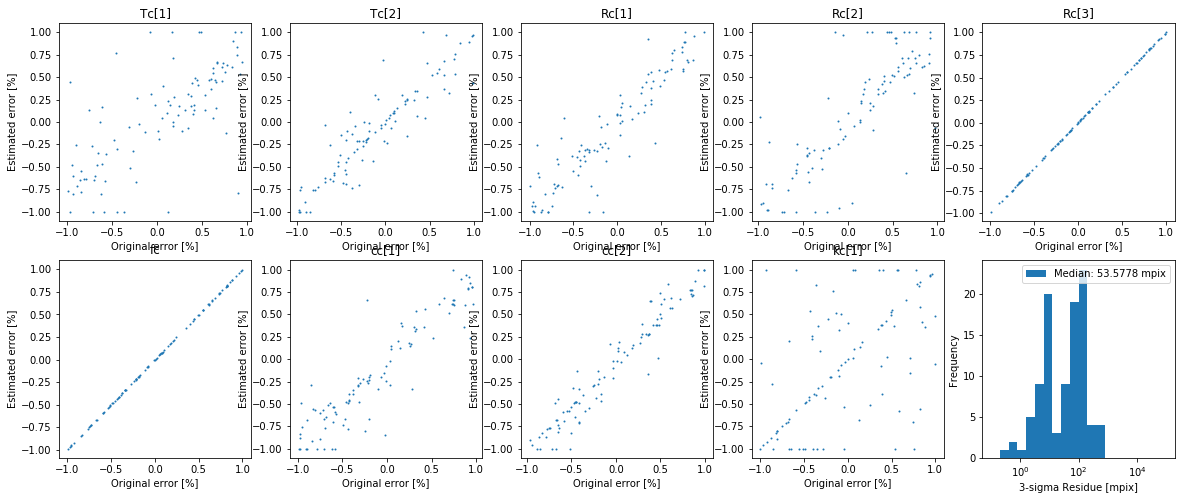

In [32]:
for iSet in [1,2,5,10,20,50,100]:
#for iSet in [2,5,10,20,50,100]:
    TestFitting("GB_%03dset.pdf" % (iSet),iSet)

### Jan. 8th, 2019

Here is the summary of the above test:

| Number of guide bundle sets | Total number of guide bundle positions | Median of $3\sigma$ residue in 100 runs \[mpix\] | \[microns\] |
|---|---|---|---|
| 1 | 19 | 17.0712 | 8.194 |
| 2 | 38 | 18.6299 | 8.942 |
| 5 | 95 | 9.50716 | 4.563 |
| **10** | **190** | **7.5691** | **3.633** |
| 20 | 380 | 203.534 | 97.696 |
| 50 | 950 | 54.8239 | 26.315 |
| 100 | 1900 | 53.5778 | 25.717 |


Here are some lessons:
- Only a single set of guide bundles can give the $3\sigma$ residue as the ~25% of the requirement.
- 5~10 sets of guide bundles give the best results. In this case, the $3\sigma$ residue only from the intrinsic/extrinsic parameter error is 10~15% of the requirement. Of course, this does not automatically guarantee the success of the entire metrology camera calibration, since (1) the error range of the parameters are only +/-1% here, and (2) the above test does not consider the centroid error at all.
- More than 20 sets of guide bundles do not enhance the results. Instead, the result is worse than a single set of guide bundles. This can be probably due to the too many number of input parameters for the least square fitting. Or, this can be because the random error generation of intrinsic/extrinsic parameters are different in different runs.

With the above lessons, let's do the following additional tests.
- What happens if we use the same set of random error generations for all tests and increase the runs (e.g., 500)?
- What happens if we increase the allowed error range from +/-1% to +/-5% (except Rc[3]; less than +/-2%)?
- What happens if we also test other configurations (camera-2 and 3)?

## Fix the random error generation; 500 runs; +/-1%

In [14]:
Nvar = 500
randVar = np.random.rand(Nvar,13)*2-1.

In [15]:
def TestFitting(filename,Nset):

    WIDTH,HEIGHT = 2448,2050

    # Get the fiducial choice for camera 1
    prefix = "MANIFEST_sim_001_coord_data_camera-1"
    params = GetFiducialParameter(prefix)
    plateTarget = ReadPlatePos(prefix)
    plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
    pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

    pixGBFidSet = np.array([ConvertPlateToPix(plateGB,params) for plateGB in plateGBSet[:Nset]])

    plt.clf()
    fig,axs = plt.subplots(2,5,figsize=(20,8))
    axs = axs.flatten()

    # Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
    arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
    arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

    errBudget = []
    for rv,ivar in zip(randVar,range(1,Nvar+1)):
        newParams = ChangeFullFiducialParameter(params,rv)
        pixTarget = ConvertPlateToPix(plateTarget,newParams)
        pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        pixGBSet = np.array([ConvertPlateToPix(plateGB,newParams) for plateGB in plateGBSet[:Nset]])
        
        pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
        plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
        
        """
        pixGBSubSet = np.array([CollectPixWithinFrame(pixGB,WIDTH,HEIGHT) for pixGB in pixGBSet])
        plateGBSubSet = np.array([GetFiducialSubset(plateGB,pixGBFid,pixGBSub) for plateGB,pixGBFid,pixGBSub 
                                  in zip(plateGBSet[:Nset],pixGBFidSet,pixGBSubSet)])
        
        print("Shapes of pixGBSet, pixGBSubSet, plateGBSubSet: ",pixGBSet.shape,pixGBSubSet.shape,plateGBSubSet.shape)
        print("pixGBSubSet: ",pixGBSubSet)
        print("plateGBSubSet: ",plateGBSubSet)
        
        pixGBSub = pixGBSubSet.reshape((-1,2))
        plateGBSub = plateGBSubSet.reshape((-1,3))
        """
        pixGBSub,plateGBSub = [],[]
        for tmpPixGB,tmpPlateGB,tmpPixGBFid in zip(pixGBSet,plateGBSet[:Nset],pixGBFidSet):
            tmpPixGBSub = CollectPixWithinFrame(tmpPixGB,WIDTH,HEIGHT)
            tmpPlateGBSub = GetFiducialSubset(tmpPlateGB,tmpPixGBFid,tmpPixGBSub)
            pixGBSub.extend(tmpPixGBSub)
            plateGBSub.extend(tmpPlateGBSub)
            
        pixGBSub,plateGBSub = np.array(pixGBSub),np.array(plateGBSub)
        #print("Shapes of pixGBSub, plateGBSub: ",pixGBSub.shape,plateGBSub.shape)
        
        """
        print("pixFiducialSub: ",pixFiducialSub.shape," pixGBSub: ",pixGBSub.shape,flush=True)
        print("vstack(pixFiducialSub,pixGBSub): ",np.vstack([pixFiducialSub,pixGBSub]).shape)
        return
        """
        plateSub = np.vstack([plateFiducialSub,plateGBSub])
        pixSub = np.vstack([pixFiducialSub,pixGBSub])
        
        estParams = RecalibrateParameter(plateSub,pixSub,params)
        arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
        arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
        arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
        arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
        arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
        arrFcE.append((estParams.fc-params.fc)/params.fc*100)
        arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
        arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
        arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

        estPixTarget = ConvertPlateToPix(plateTarget,estParams)
        residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
        errBudget.append(np.percentile(residues,99.865))
        print("\r","Done sample %3d" % (ivar),end='',flush=True)

    for ax,orig,est,valType in zip(axs[:-1],
                                   [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                                   [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                                   ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
        ax.scatter(orig,est,s=1,rasterized=True)
        ax.set_title(valType)
        ax.set_xlabel("Original error [%]")
        ax.set_ylabel("Estimated error [%]")
    
    axs[-1].hist(errBudget,bins=np.logspace(-1,5,21),label="Median: %G mpix" % (np.median(errBudget)))
    axs[-1].set_xlabel("3-sigma Residue [mpix]")
    axs[-1].set_xscale("log")
    axs[-1].set_ylabel("Frequency")
    axs[-1].legend()
    plt.savefig("output/%s" % (filename),bbox_inches="tight",dpi=150)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


 Done sample 500

<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

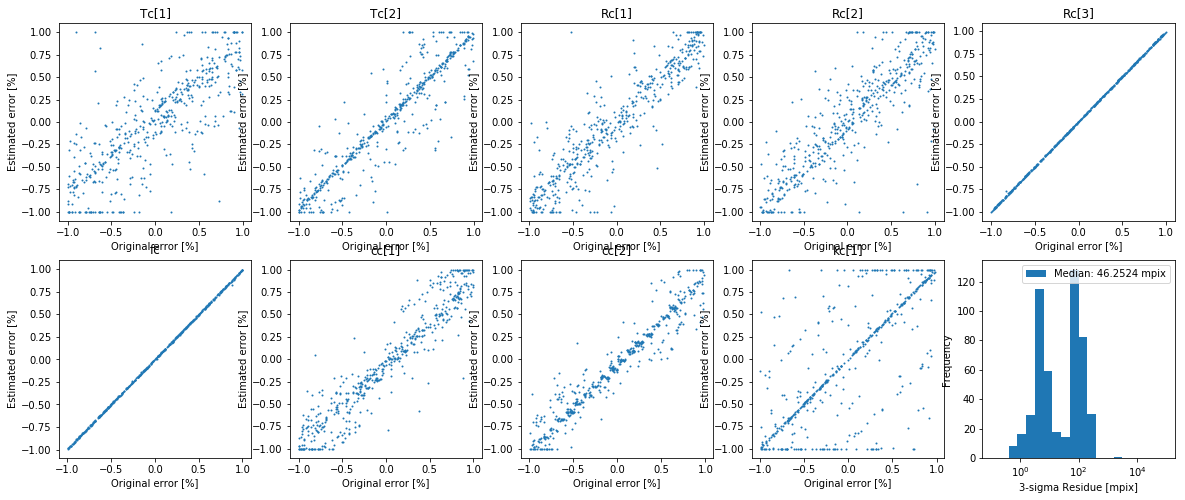

In [16]:
for iSet in [1,2,5,10,20,50,100]:
    TestFitting("fixRand_500run_1percent/GB_%03dset.pdf" % (iSet),iSet)

| Number of guide bundle sets | Total number of guide bundle positions | Median of $3\sigma$ residue in 500 runs \[mpix\] | \[microns\] |
|---|---|---|---|
| 1 | 19 | 16.2091 | 7.780 |
| 2 | 38 | 11.7304 | 5.631 |
| **5** | **95** | **6.69607** | **3.214** |
| **10** | **190** | **6.02736** | **2.893** |
| 20 | 380 | 6.41994 | 3.082 |
| 50 | 950 | 13.1717 | 6.322 |
| 100 | 1900 | 46.2524 | 22.201 |

Here is the lessons:
- By using identical 500 runs, the median values of $3\sigma$ residues decrease in overall. This could be a good sign.
- By considering the efficiency, we don't need to measure more than 5 sets of guide bundle positions. 10 sets give bertter residue (< 10% of requirement), but such enhancement is not that efficient. Even 5 sets can give 10.7% of the requirement.
- Again, having more than 20 sets is not beneficial at all, at least in this Python-based script. While the median value (3.082um) at 20 sets looks a bit reasonable, the overall distribution of residues or parameter estimation becomes quite worse than 10-set case. Since we used the identical random errors, the most plausible reason is that number of input parameters from positions from 20 sets of guide bundles was too large to be optimized with ``scipy.optimize.least_square``.
- While this is a bit subtle, but cc\[2\] parameter seems to be fit in a discrete manner. Probably there is a chance to improve the fitting if we handle this issue.

### Jan. 9th, 2018
## Fix random error generation; 500 runs; +/-5% (except Rc\[3\] --- +/-1.5%)

In [17]:
randVar *= 5.
randVar[:,4] *= 0.3  # Rc[3] should not surpass +/-2%!

In [18]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalParam = [Tc[0],Tc[1],Rc[2],fc,cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalFid = np.array([paramsFid.Tc[0],paramsFid.Tc[1],paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    probableFid = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundantFid = np.copy(paramsFid.kc[1:])
        
    criticalLP,criticalHP = criticalFid*0.95,criticalFid*1.05
    probableLP,probableHP = probableFid*0.95,probableFid*1.05
    
    criticalLB = np.minimum(criticalLP,criticalHP) + np.array([-np.abs(paramsFid.Tc[1]*0.05),0.,0.,0.,0.,0.],dtype=np.float64)
    criticalUB = np.maximum(criticalLP,criticalHP) + np.array([np.abs(paramsFid.Tc[1]*0.05),0.,0.,0.,0.,0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -5E-6 * np.ones(4), 5E-6 * np.ones(4)
    
    # 2. Calibrate criticalParam --> probableParam --> redundantParam
    # Here, calibrate multiple times
    critical,probable,redundant = np.copy(criticalFid),np.copy(probableFid),np.copy(redundantFid)
    for iteration in range(100):
        criticalOld,probableOld,redundantOld = np.copy(critical),np.copy(probable),np.copy(redundant)
        critical = opt.least_squares(ResidueChangeCritical,criticalOld,
                                     args=(arrPlate,arrPix,probableOld,redundantOld),
                                     bounds=(criticalLB,criticalUB),
                                     ftol=1E-16,xtol=1E-16).x
        probable = opt.least_squares(ResidueChangeProbable,probableOld,
                                     args=(arrPlate,arrPix,critical,redundantOld),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
        redundant = opt.least_squares(ResidueChangeRedundant,redundantOld,
                                      args=(arrPlate,arrPix,critical,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((critical-criticalOld)/criticalOld)),
                  np.amax(np.abs((probable-probableOld)/probableOld)),
                  np.amax(np.abs((redundant-redundantOld)/redundantOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(critical,probable,redundant)
    return newParam

In [ ]:
from multiprocessing import Pool
p = Pool()
p.map(TestFitting,[("fixRand_500run_5percent/GB_%03dset.pdf" % (iSet),iSet) for iSet in [1,2,5,10,20]],chunksize=1)

... This will be done separately.

| Number of guide bundle sets | Total number of guide bundle positions | Median of $3\sigma$ residue in 500 runs \[mpix\] | \[microns\] |
|---|---|---|---|
| 1 | 19 | 49194.4 | 23613 |
| 2 | 38 | 38194.1 | 18333 |
| 5 | 95 | 26182.5 | 12568 |
| 10 | 190 | 18240.4 | 8755.4 |
| 20 | 380 | 12386.5 | 5945.5 |
| 50 | 950 | 7709.11 | 3700.4 |

In this case, both the Rc\[3\] and fc were not fit well, compared to the +/-1% case.
Is it probably because of the error range for Rc\[3\] (+/-1.5%) is not good enough?
What happens if we keep everything the same, except the Rc\[3\] with +/-1%?

### Jan. 10th, 2018
## Fix random error generation; 500 runs; +/-5% (except Rc\[3\] --- +/-1%)